In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

import copy

from tqdm import tqdm

# import sys
# sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

In [3]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]
fav_image_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)

In [4]:
# from distortion import sparse_transform_amplitude, create_grid_sample, find_inv_grid, jacobian_det, get_version
from utils.distortion import create_grid_sample
from utils.diffeo_container import diffeo_container, sparse_diffeo_container
from utils.get_model_activation import retrieve_layer_activation

## Composition

In [5]:
sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(5, 5, 3, 0.1, 10)
sparse_diffeos.get_all_grid()
diffeo_composed = sparse_diffeos.get_composition(level = 1)
diffeo_composed.up_down_sample(56, 56)
diffeo_composed.up_down_sample(28, 28)
diffeo_composed.up_down_sample(14, 14)
diffeo_composed.up_down_sample( 7,  7)
index_dict = diffeo_composed.element_to_index

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [7]:
ToImage = v2.ToPILImage()
distorted_image = t.nn.functional.grid_sample(fav_image.unsqueeze(0).repeat(len(diffeo_composed[2]),1,1,1), diffeo_composed[2], mode = 'bilinear')

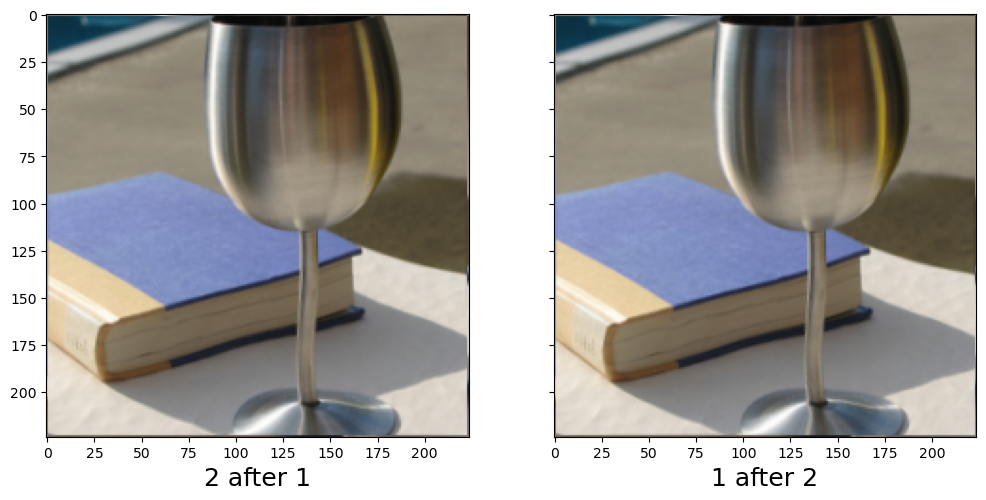

In [8]:
index_dict['g1g2'][1]
fig, axes = plt.subplots(1,2, figsize = (12,6), sharey=True)
axes[0].imshow(ToImage(distorted_image[index_dict['g2g1'][1]]));
axes[0].set_xlabel('2 after 1', fontsize=18);
axes[1].imshow(ToImage(distorted_image[index_dict['g1g2'][1]]));
axes[1].set_xlabel('1 after 2', fontsize=18);

# cax = axes[3].matshow(t.linalg.vector_norm((distorted_again - fav_image.unsqueeze(0)).squeeze(), dim = 0));
# axes[3].set_xlabel(r'|A|=1', fontsize=18);
# fig.colorbar(cax)

## Get Activation with inverse adjust

In [23]:
from utils.get_model_activation import retrieve_layer_activation

In [6]:
sparse_diffeos = sparse_diffeo_container(224, 224)
diffeo_strength_list = [0.01, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.4, 0.45, 0.5]
for strength in diffeo_strength_list:
    sparse_diffeos.sparse_AB_append(4, 4, 3, strength, 100)
sparse_diffeos.get_all_grid()
sparse_diffeos.to(device)
# sparse_diffeos.get_inverse_grid()

In [6]:
path = 'data/temp_inv_data/'
t.save(sparse_diffeos.inverse, path + '15-100-4-4-3-224-224_inv_grid_sample.pt')

In [ ]:
imagenet_val_loader = iter(t.utils.data.DataLoader(imagenet_val_inference, batch_size = 1, shuffle=False))
path = 'data/temp_inv_data'
#t.save(grid_sample, path + '20-50-10-10-3-224-224_grid_sample.pt')
for i in tqdm(range(100)):
  file_prefix = f'15-100-4-4-3-224-224_image-{i:04d}_activation'
  val_image, _ = next(imagenet_val_loader)
  grid_sample = t.cat(sparse_diffeos.diffeos)
  distorted_list = t.nn.functional.grid_sample(val_image.repeat(15 * 100,1,1,1).to(device), grid_sample, mode = 'bilinear')
  activation = retrieve_layer_activation(ENV2, distorted_list, [5,9,13,19,28,36,43,46,49])
  for key in activation.keys():
    t.save(activation[key], path + file_prefix + f'_layer-{int(key):02d}.pt')
  activation = {}
  handle = []


## Learn h inverse

In [5]:
from utils.distortion import mix_channel_2d
toImage = v2.ToPILImage()

In [6]:
diffeo = sparse_diffeo_container(224, 224)
diffeo.sparse_AB_append(4, 4, 3, 0.5, 1)
diffeo.get_all_grid()
inv_diffeo = diffeo.get_inverse_grid(base_learning_rate=300)

  0%|          | 17/10000 [00:00<00:59, 167.76it/s]

 48%|████▊     | 4759/10000 [00:16<00:17, 291.31it/s]


In [20]:
goblet_range = list(range(28600, 28650))
goblet_range.remove(fav_pic_index)
images = t.stack([imagenet_val_inference[index][0] for index in goblet_range])

In [21]:
distorted_image = F.grid_sample(images, diffeo[0].repeat(49,1,1,1))

In [52]:
activation = retrieve_layer_activation(ENV2, images, [5])
ref_act = copy.deepcopy(activation)

In [53]:
activation = retrieve_layer_activation(ENV2, distorted_image, [5])
diffeo_act = copy.deepcopy(activation)

In [73]:
down_sampled = diffeo.inverse.up_down_sample(112, 112)
un_diffeo = F.grid_sample(diffeo_act['5'], down_sampled[0].repeat(49,1,1,1))

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


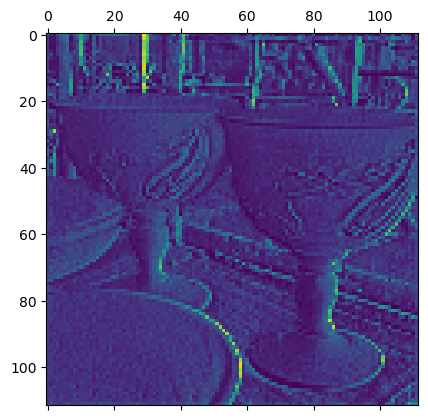

In [55]:
plt.matshow(ref_act['5'][2,6])

In [1]:
ref_act['5'].shape

NameError: name 'ref_act' is not defined

In [70]:
h_inverse = mix_channel_2d(24, 112, 112)

In [ ]:
loss_hist = []
loss_fn = nn.MSELoss()
optimizer = t.optim.SGD(h_inverse.parameters(), lr = 0.01)
num_epochs = 10000
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = h_inverse(un_diffeo)
    loss = loss_fn(output, ref_act['5'])
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
          loss_hist.append(loss.item())
          print(f'loss: {loss.item:.4f}')
    
h_inverse_matrix = h_inverse.weight.detach().clone()

## Learn A,B amplitude

In [7]:
fav_image_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0).to(device)
toImage = v2.ToPILImage()

In [8]:
sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(1,5,1,0.3,1)
sparse_diffeos.get_all_grid()
sparse_diffeos.to(device)
inv_grid = sparse_diffeos.get_inverse_grid(base_learning_rate=200)

 51%|█████     | 5119/10000 [00:17<00:16, 294.35it/s]


In [9]:
class add_bias_to_AB(nn.Module):
  def __init__(self, AB, extra_freq_scaling = 1):
    # grid should have the shape of a grid_sample grid, i.e. (Channel, X, Y, 2)
    super().__init__()
    _, _, x_cutoff, y_cutoff = AB.shape
    self.AB = F.pad(AB,(0,(extra_freq_scaling) * y_cutoff, 0, (extra_freq_scaling) * x_cutoff),mode = 'constant', value = 0)
    # self.bias = nn.Parameter(self.AB.abs().sum() * (t.randint_like(self.AB, 1) - 1/2)/self.AB.numel())
    # self.bias = nn.Parameter(t.rand_like(self.AB))
    self.bias = nn.Parameter(t.rand_like(self.AB)/self.AB.numel())
    self.result = AB
  def forward(self):
    self.result = self.bias + self.AB
    return self.result
  @property
  def result_magnitude(self):
    return self.result[0].detach().abs().sum(), self.result[1].detach().abs().sum()
  @property
  def bias_magnitude(self):
    return self.bias[0].detach().abs().sum(), self.bias[1].detach().abs().sum()
  @property
  def original_magnitude(self):
    return self.AB[0].detach().abs().sum(), self.AB[1].detach().abs().sum()


In [20]:
AB_original = t.cat([t.stack(sparse_diffeos.A), t.stack(sparse_diffeos.B)])
AB = add_bias_to_AB(-AB_original.to(device), extra_freq_scaling = 1).to(device)
# AB = add_bias_to_AB(t.zeros_like(-AB_original).to(device), extra_freq_scaling = 0).to(device)
loss_fn = nn.MSELoss()
loss_l1 = nn.L1Loss()
loss_hist = []
AB_mag = []

In [21]:
from utils.distortion import compose_diffeo_from_left

# optimizer = t.optim.SGD(AB.parameters(), lr = 0.1, weight_decay = 0.01)
optimizer = t.optim.Adam(AB.parameters(), lr = 0.1, weight_decay = 0.01)
# optimizer = t.optim.SGD(AB.parameters(), lr = 1e-1)
# scheduler = t.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=1e-2, patience = 5)

num_epochs = 1000
# ref_grid = compose_diffeo_from_left(inv_grid[0],sparse_diffeos[0]).to(device)
id_grid = sparse_diffeos.get_id_grid()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    new_AB = AB()
    with t.device(device):
        grid = create_grid_sample(224, 224, new_AB[0], new_AB[1])
    un_distorted = compose_diffeo_from_left(grid,sparse_diffeos[0])
    unreg_loss = loss_fn(un_distorted, id_grid)
    loss = unreg_loss * (1 + 0.1 * AB.result.abs().sum()/AB.AB.abs().sum())
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

    if (epoch) % 50 == 0:
          with t.no_grad(): 
            loss_hist.append(unreg_loss.item())
            AB_mag.append(AB.result.abs().sum().item()/2)
            AB.bias[t.abs(AB.bias) < 1e-7] = 0
          # print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:32<00:00, 30.31it/s]


1.1655625712592155e-05
0.32909929752349854


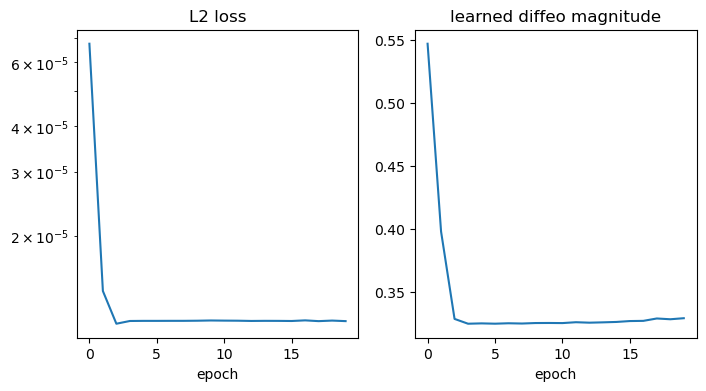

In [22]:
fig, axes = plt.subplots(1,2, figsize = (8,4))
axes[0].plot(loss_hist)
axes[0].set_yscale('log')
axes[0].set_title('L2 loss')
axes[0].set_xlabel('epoch')
axes[1].plot(AB_mag)
axes[1].set_title('learned diffeo magnitude')
axes[1].set_xlabel('epoch')
print(loss_hist[-1])
print(AB_mag[-1])

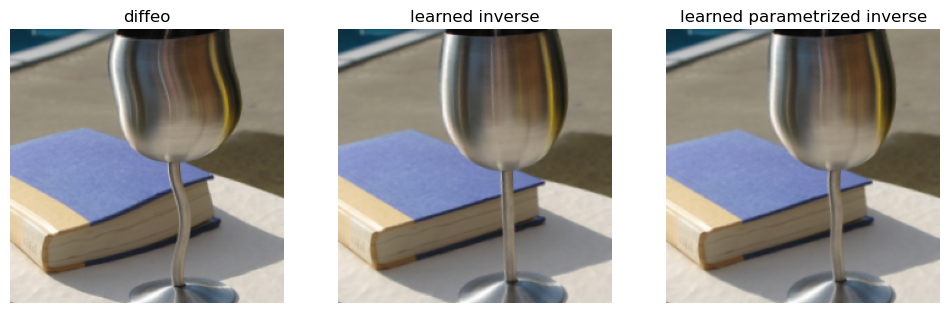

In [23]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(toImage(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0].squeeze()))
axes[0].set_title('diffeo')
axes[1].imshow(toImage(inv_grid(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0])[0].squeeze()))
axes[1].set_title('learned inverse')
axes[2].imshow(toImage(F.grid_sample(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0], grid, align_corners = True).squeeze()))
axes[2].set_title('learned parametrized inverse')
[ax.axis('off') for ax in axes];

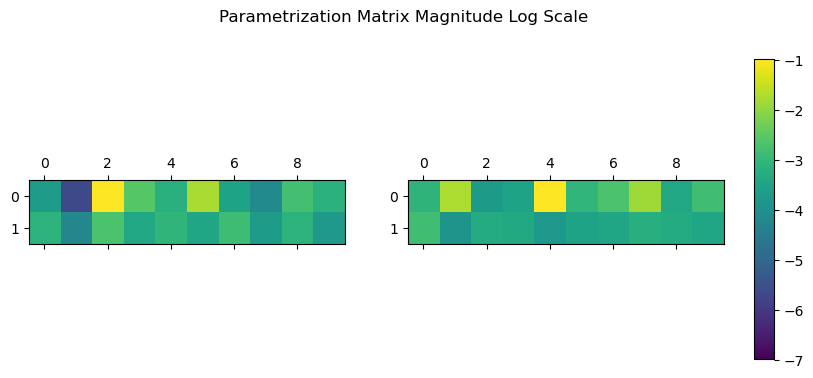

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
cb = axes[1].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax)
fig.suptitle('Parametrization Matrix Magnitude Log Scale', y=0.9);

In [58]:
AB_original = t.cat([t.stack(sparse_diffeos.A), t.stack(sparse_diffeos.B)])
AB = add_bias_to_AB(-AB_original.to(device)).to(device)
loss_fn = nn.MSELoss()
loss_l1 = nn.L1Loss()
history_lbfgs = []

In [59]:
optimizer = t.optim.LBFGS(AB.parameters(),
                    lr = 1,
                    line_search_fn='strong_wolfe')

num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    def closure():
        optimizer.zero_grad()
        new_AB = AB()
        with t.device(device):
            grid = create_grid_sample(224, 224, new_AB[0], new_AB[1])
        loss = loss_fn(grid, inv_grid[0].to(device)) + 0.001 * AB.bias.abs().sum()
        loss.backward()
        history_lbfgs.append(loss.item())
        return loss
    optimizer.step(closure)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


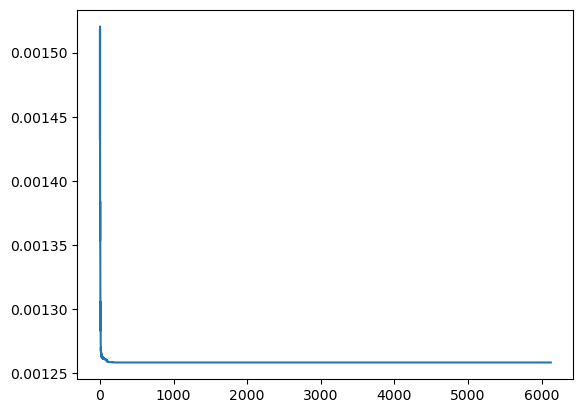

In [60]:
plt.plot(history_lbfgs)

## Verify cosine similarity calculation

In [188]:
ref_path = 'data/reference/'
diffed_path = 'data/all_cnn_layers/'
layer = 30
image = 70
ref_image = t.load(ref_path + f'val_image-{image:04d}_activation_layer-{layer:02d}.pt', map_location='cpu')
image = t.load(diffed_path + f'15-100-4-4-3-224-224_image-{image:04d}_activation_layer-{layer:02d}.pt', map_location='cpu')
image.shape

torch.Size([1500, 256, 7, 7])

In [190]:
inv_grid = t.load(diffed_path + '15-100-4-4-3-224-224_inv_grid_sample.pt', map_location='cpu')
inv_grid = diffeo_container(224, 224, [t.cat(inv_grid)])
downsampled = inv_grid.up_down_sample(7,7, mode='nearest')

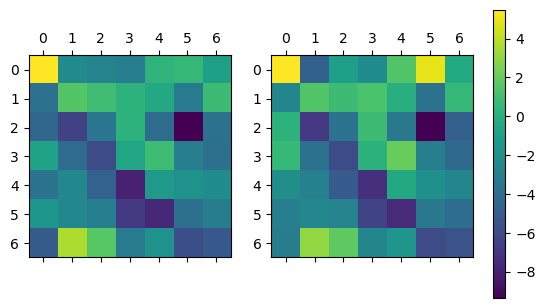

In [191]:
channel = 10
diffeo_index = 0
fig, axes = plt.subplots(1, 2)
axes[0].matshow((ref_image[0,channel]))
undistort = F.grid_sample(image[diffeo_index,channel].unsqueeze(0).unsqueeze(0),downsampled[0,diffeo_index].unsqueeze(0), mode = 'nearest', padding_mode='border')
cb = axes[1].matshow(image[diffeo_index,channel])
cb = axes[1].matshow(undistort.squeeze())
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax);

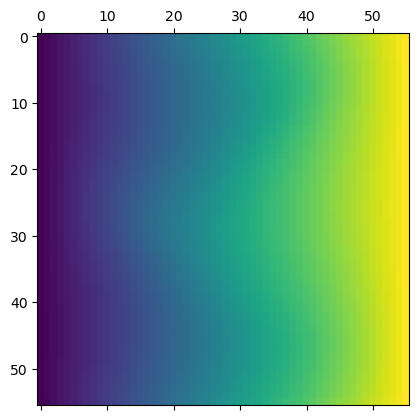

In [158]:
plt.matshow(downsampled[0,-1,:,:,0], vmin = -1, vmax = 1)

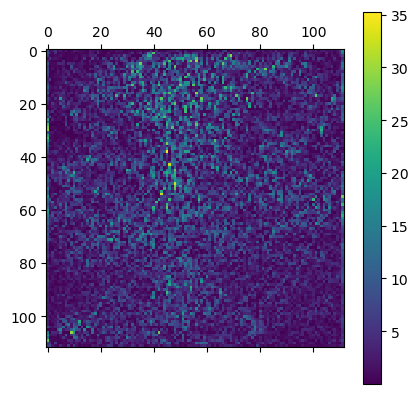

In [16]:
channel = 0
plt.matshow((ref_image[0,channel] - image[-1,channel]).abs())
plt.colorbar()

In [19]:
channel = 10
diffeo_index = 0
similarity = []
for diffeo_index in range(len(image)):
    similarity.append(F.normalize(ref_image[0,channel].flatten(), dim = 0) @ F.normalize(image[diffeo_index,channel].flatten(), dim = 0))

In [20]:
t.Tensor(similarity).mean()

tensor(0.8567)

In [192]:
F.normalize(ref_image[0,channel].flatten(), dim = 0) @ F.normalize(undistort.flatten(), dim = 0)

tensor(0.9497)

In [193]:
F.normalize(ref_image[0,channel].flatten(), dim = 0) @ F.normalize(image[diffeo_index,channel].flatten(), dim = 0)

tensor(0.9497)

## Random/Scrambled weight CNN

In [ ]:
scrambled_ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
scrambled_ENV2.eval();

state_dict = scrambled_ENV2.state_dict()

for name, param in state_dict.items():
    # if 'weight' in name:
    # Transform the parameter as required.
    param_shape = param.shape
    permuted_param = param
    for i, dim_size in enumerate(param_shape):
        if i == 1:
            perm_indices = t.randperm(dim_size)
            permuted_param = permuted_param.index_select(i, perm_indices)
    
    # Update the parameter.
    param.copy_(permuted_param)

In [ ]:
rand_ENV2 = tv.models.efficientnet_v2_s().to(device)
rand_ENV2.eval();

## Verify near zero diffeo cosine similarity

In [8]:
sparse_diffeo = sparse_diffeo_container(224, 224)
sparse_diffeo.sparse_AB_append(4,4,3,0.001,20)
sparse_diffeo.get_all_grid()

In [9]:
distorted = F.grid_sample(fav_image_inf.repeat(20,1,1,1), sparse_diffeo[0], mode = 'bilinear', align_corners=True)

In [141]:
similarity = t.einsum('ip, ip -> i', F.normalize(ENV2(fav_image_inf)).repeat(20,1), F.normalize(ENV2(distorted)))

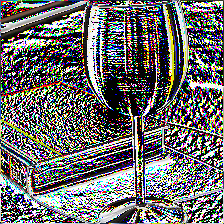

In [11]:
v2.ToPILImage()((fav_image_inf - F.grid_sample(fav_image_inf, sparse_diffeo[0,0].unsqueeze(0), mode = 'bilinear', align_corners=False)).squeeze())

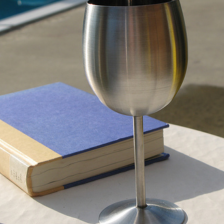

In [95]:
v2.ToPILImage()(fav_image)

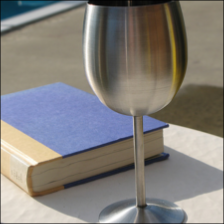

In [94]:
v2.ToPILImage()(distorted[-2])

In [56]:
t.allclose(sparse_diffeo.get_id_grid(), sparse_diffeo.diffeos[0][0])

True

## Activation Steering

In [16]:
a = t.rand(20*10, 1280, 7, 7)
a.element_size() * a.nelement()

50176000

In [6]:
from utils.get_model_activation import get_flatten_children, inv_diff_hook, retrieve_layer_activation

In [12]:
diffeo = sparse_diffeo_container(224, 224)
diffeo.sparse_AB_append(3,3,3,0.5,50)
diffeo.get_all_grid()
diffeo.to(device)
inv_diffeo = diffeo.get_inverse_grid(base_learning_rate=1000)

 38%|███▊      | 3799/10000 [00:02<00:03, 1702.43it/s]


In [8]:
inv_diffeo_7 = inv_diffeo.up_down_sample(7, 7, align_corners=True) # layer 29-43
inv_diffeo_14 = inv_diffeo.up_down_sample(14, 14, align_corners=True) # layer 14-28
inv_diffeo_28 = inv_diffeo.up_down_sample(28, 28, align_corners=True) # layer 10-13
inv_diffeo_56 = inv_diffeo.up_down_sample(56, 56, align_corners=True) # layer 6-9
inv_diffeo_112 = inv_diffeo.up_down_sample(112, 112, align_corners=True) # layer 3-5
inv_diffeo_7.to(device)
inv_diffeo_14.to(device)
inv_diffeo_28.to(device)
inv_diffeo_56.to(device)
inv_diffeo_112.to(device)

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
layers = get_flatten_children(ENV2)
ref = ENV2(fav_image_inf.to(device))

In [10]:
handle_1 = layers[38-1].register_forward_hook(inv_diff_hook(inv_diffeo_7, batch_size = 50))
handle_2 = layers[43-1].register_forward_hook(inv_diff_hook(inv_diffeo_7, batch_size = 50))
activation, steered = retrieve_layer_activation(ENV2, diffeo(fav_image_inf.repeat(50,1,1,1).to(device), in_inference=True), range(10,30))
handle_1.remove()
handle_2.remove()

In [11]:
steered.shape

torch.Size([150, 1000])

In [12]:
t.einsum('ap, ap -> a', F.normalize(steered), F.normalize(ref))

tensor([0.8937, 0.9076, 0.9012, 0.7691, 0.8915, 0.8967, 0.9113, 0.8837, 0.7845,
        0.8511, 0.8396, 0.9013, 0.8274, 0.8665, 0.9163, 0.8846, 0.8850, 0.7942,
        0.9042, 0.8704, 0.8464, 0.8523, 0.8595, 0.9235, 0.9258, 0.9002, 0.8185,
        0.9078, 0.7922, 0.6039, 0.8394, 0.8562, 0.8219, 0.9257, 0.8550, 0.8875,
        0.8046, 0.9098, 0.8759, 0.7406, 0.8960, 0.7916, 0.9293, 0.8363, 0.8769,
        0.8384, 0.8590, 0.8334, 0.8170, 0.8709, 0.8779, 0.8980, 0.8924, 0.7655,
        0.8832, 0.8885, 0.8911, 0.8778, 0.7746, 0.8427, 0.8351, 0.8964, 0.8529,
        0.8500, 0.9096, 0.8480, 0.8843, 0.7897, 0.8972, 0.8487, 0.8346, 0.8237,
        0.8670, 0.9043, 0.9218, 0.8970, 0.8006, 0.9039, 0.7890, 0.5743, 0.7703,
        0.8481, 0.7737, 0.9259, 0.8317, 0.8760, 0.8072, 0.8918, 0.8673, 0.7437,
        0.8951, 0.7625, 0.9145, 0.8184, 0.8528, 0.8101, 0.8698, 0.8294, 0.8212,
        0.8683, 0.8951, 0.9058, 0.9097, 0.7691, 0.9006, 0.8921, 0.9007, 0.8816,
        0.7834, 0.8540, 0.8486, 0.9007, 

In [12]:
_.mean()

tensor(0.8578, device='cuda:0')

In [23]:
(-1,)+tuple(activation['20'].shape)[1:]

(-1, 160, 14, 14)

In [19]:
activation['20'].reshape(((-1),tuple(activation['20'].shape)))

TypeError: reshape(): argument 'shape' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got tuple"

In [13]:
for values in activation.values():
    print(values.shape)

torch.Size([50, 64, 28, 28])
torch.Size([50, 64, 28, 28])
torch.Size([50, 64, 28, 28])
torch.Size([50, 64, 28, 28])
torch.Size([50, 128, 14, 14])
torch.Size([50, 128, 14, 14])
torch.Size([50, 128, 14, 14])
torch.Size([50, 128, 14, 14])
torch.Size([50, 128, 14, 14])
torch.Size([50, 128, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 160, 14, 14])
torch.Size([50, 256, 7, 7])
